# Coursera: Capstone Project "The Battle of Neighborhoods"
## Title: "Madrid: Best neighborhoods to raise a family"
## Author: Leonardo Barrientos C.

### Introduction

To problem is to find the right neighborhoods to raise a family in Madrid (Spain, EU) based on key factors that are meaningful for families. 

### Data

The Foursquare API information is used to calculate frequency of the categories of venues of Neighborhoods, like schools and playgrounds, also some census information is used. The Neighborhoods are clustered according to predominant information that is considered related to guarantee to be a good place to rise a family.

Key factors of a good Neighborhoods to raise a Family:

1. Schools venues
1. GDP (Municipality/Borough)
1. Recreation & Family amenities (Playground, Parks, Plaza)

***Due to foursquare API daily limitation only Average Gross Incoming from quantil 75 is considered***


#### Function & utilities to get data

In [371]:
import os
import json, requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

In [372]:
%load_ext dotenv
%dotenv 

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [373]:
defaultLatLong = [40.416775, -3.703790]

### Madrid - Data location from Municipalities / Borough

Source: https://xn--cdigospostales-lob.es/listado-de-codigos-postales-de-espana/

In [374]:
dfLocationRaw = pd.read_csv('https://xn--cdigospostales-lob.es/wp-content/uploads/2018/09/listado-codigos-postales-con-LatyLon.csv', sep=';')

In [375]:
dfLocationRaw.head()

,provincia,poblacion,codigopostalid,lat,lon
0,Araba/Álava,Alegría-Dulantzi,240,-2.712437,42.939812
1,Araba/Álava,Alegría-Dulantzi,1193,-2.712437,42.939812
2,Araba/Álava,Amurrio,1450,-3.000073,43.054278
3,Araba/Álava,Amurrio,1468,-3.000073,43.054278
4,Araba/Álava,Amurrio,1470,-3.000073,43.054278


Filter Madrid CP

In [376]:
dfLocationMadrid = dfLocationRaw[dfLocationRaw['provincia'].str.contains('Madrid')] \
            .drop(['provincia'], axis = 1) \
            .rename(columns = { 'poblacion': 'Neighborhood', 'codigopostalid': 'Postal code', 'lat': 'Longitude', 'lon': 'Latitude'}) \
            .drop(['Postal code'], axis = 1) \
            .sort_values('Neighborhood') \
            .drop_duplicates() \
            .reset_index(drop = True) 

dfLocationMadrid.head(5)

,Neighborhood,Longitude,Latitude
0,Ajalvir,-3.480710,40.535068
1,Alameda del Valle,-3.843662,40.916583
2,Alcalá de Henares,-3.369251,40.480332
3,Alcobendas,-3.632402,40.541042
4,Alcorcón,-3.828495,40.351570


In [377]:
len(dfLocationMadrid.index)

178

### Madrid - Data poblation & Areas from Municipalities / Borough

Source: https://es.wikipedia.org/wiki/Anexo:Municipios_de_la_Comunidad_de_Madrid

In [378]:
dfPoblationRaw = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Municipios_de_la_Comunidad_de_Madrid')[0]

In [379]:
dfPoblationRaw.head()

,Nombre,Población(2017),Superficie (km²)[1]​,Mapa,Escudo,Capitalidad[1]​,Altitud(msnm)[a]​[2]​
0,La Acebeda,66,2206,NaN,NaN,La Acebeda,1271
1,Ajalvir,4455,1962,NaN,NaN,Ajalvir,680
2,Alameda del Valle,199,2501,NaN,NaN,Alameda del Valle,1104
3,El Álamo,9149,2225,NaN,NaN,El Álamo,608
4,Alcalá de Henares,194 310,8772,NaN,NaN,Alcalá de Henares,587


In [380]:
dfPoblationMadrid = dfPoblationRaw \
            .rename(columns={dfPoblationRaw.columns[0]: 'Neighborhood', dfPoblationRaw.columns[1]: 'Population', dfPoblationRaw.columns[2]: 'Area (km2)', dfPoblationRaw.columns[5]: 'Capital', dfPoblationRaw.columns[6]: 'Altitud' }) \
            .drop(['Mapa','Escudo','Capital','Altitud'], axis = 1) \
            .sort_values('Neighborhood') \
            .drop_duplicates() \
            .reset_index(drop = True) 

dfPoblationMadrid['Population'] = dfPoblationMadrid['Population'].apply(lambda x: ''.join(filter(str.isdigit, x))).astype(int)
dfPoblationMadrid['Area (km2)'] = dfPoblationMadrid['Area (km2)'].astype(int)
dfPoblationMadrid.head()

,Neighborhood,Population,Area (km2)
0,Ajalvir,4455,1962
1,Alameda del Valle,199,2501
2,Alcalá de Henares,194310,8772
3,Alcobendas,114864,4498
4,Alcorcón,168141,3373


In [381]:
len(dfPoblationMadrid.index)

179

### Madrid - Average gross income Municipalities / Borough

Source: https://www.agenciatributaria.es/AEAT/Contenidos_Comunes/La_Agencia_Tributaria/Estadisticas/Publicaciones/sites/irpfmunicipios/2017/jrubik5c71ccbbf784b68bb03524d7a59879e024c6c9e2.html

In [382]:
dfAverageGrossIncomeRaw = pd.read_html('https://www.agenciatributaria.es/AEAT/Contenidos_Comunes/La_Agencia_Tributaria/Estadisticas/Publicaciones/sites/irpfmunicipios/2017/jrubik5c71ccbbf784b68bb03524d7a59879e024c6c9e2.html')[0]

In [383]:
dfAverageGrossIncomeRaw.head()

,Unnamed: 0,Titulares,NUMERODECLARACIONES,NUMEROHABITANTES,POSICIONAMIENTORENTA BRUTA MEDIANIVELNACIONAL,POSICIONAMIENTORENTA BRUTA MEDIANIVELAUTONÓMICO,RENTA BRUTA MEDIA,RENTA DISPONIBLEMEDIA
0,Total,23.155.025,19.913.239,43.869.668,NaN,NaN,26.618,21.834
1,Andalucía,4.091.446,3.377.881,8.382.322,NaN,NaN,22.303,18.732
2,Almería,343.509,296.111,709.340,NaN,NaN,20.144,17.034
3,Tíjola-04092,1.697,1.393,3.569,33,1,40.607,32.860
4,Almería-04013,99.016,85.620,196.851,788,46,23.999,19.857


In [384]:
### Madrid ZIP is 28XXXX
dfAverageGrossIncomeRaw = dfAverageGrossIncomeRaw[dfAverageGrossIncomeRaw['Unnamed: 0'].str.contains('-28')] 

In [464]:
dfAverageGrossIncomeMadrid = dfAverageGrossIncomeRaw \
            .rename(columns={dfAverageGrossIncomeRaw.columns[0]: 'Neighborhood', dfAverageGrossIncomeRaw.columns[6]: 'Average Gross Income'}) \
            .drop(['Titulares','NUMERODECLARACIONES','NUMEROHABITANTES','POSICIONAMIENTORENTA BRUTA MEDIANIVELNACIONAL', 'POSICIONAMIENTORENTA BRUTA MEDIANIVELAUTONÓMICO','RENTA DISPONIBLEMEDIA'], axis = 1) \
            .sort_values('Neighborhood') \
            .drop_duplicates() \
            .reset_index(drop = True) 

dfAverageGrossIncomeMadrid['Neighborhood'] = dfAverageGrossIncomeMadrid['Neighborhood'].apply(lambda x: x[0:x.find('-28')])
### Thousand separator was dot, so lets multiply by 1000
dfAverageGrossIncomeMadrid['Average Gross Income'] = dfAverageGrossIncomeMadrid['Average Gross Income'].apply(lambda x: x * 1000).astype(float)
### , Las, El, etc ...
dfAverageGrossIncomeMadrid['Neighborhood'] = dfAverageGrossIncomeMadrid['Neighborhood'].apply(lambda x: x if (x.find(',') == -1) else x[x.find(',') + 2:] + ' ' + x[0:x.find(',')])
dfAverageGrossIncomeMadrid['Neighborhood'] = dfAverageGrossIncomeMadrid['Neighborhood'].str.upper()
dfAverageGrossIncomeMadrid.head(100)


,Neighborhood,Average Gross Income
0,AGRUPACIÓN MUNICIPIOS PEQUEÑOS,23488.0
1,AJALVIR,27794.0
2,EL ALAMO,23006.0
3,ALCALÁ DE HENARES,27366.0
4,ALCOBENDAS,52347.0
...,...,...
95,SAN MARTÍN DE LA VEGA,23239.0
96,SAN SEBASTIÁN DE LOS REYES,34387.0
97,SANTA MARÍA DE LA ALAMEDA,20300.0
98,LOS SANTOS DE LA HUMOSA,25591.0


In [467]:
dfAverageGrossIncomeMadrid.shape

(133, 2)

In [468]:
dfMadridLocationAndPoblation = dfLocationMadrid.merge(dfPoblationMadrid, on = 'Neighborhood').reset_index(drop = True)
dfMadridLocationAndPoblation['Population Density (per Km^2)'] = dfMadridLocationAndPoblation['Population'] / dfMadridLocationAndPoblation['Area (km2)']
dfMadridLocationAndPoblation['Neighborhood'] = dfMadridLocationAndPoblation['Neighborhood'].str.upper()


In [469]:
dfMadridLocationAndPoblation.shape

(177, 6)

In [474]:
dfMadrid = dfMadridLocationAndPoblation.merge(dfAverageGrossIncomeMadrid, on = 'Neighborhood').reset_index(drop = True)

q97 = dfMadrid['Average Gross Income'].quantile(q=0.97)
q95 = dfMadrid['Average Gross Income'].quantile(q=0.95)
q90 = dfMadrid['Average Gross Income'].quantile(q=0.90)
q75 = dfMadrid['Average Gross Income'].quantile(q=0.75)

dfMadrid = dfMadrid[dfMadrid['Average Gross Income'] >= q75]

dfMadrid['Average Gross Income Q97'] = dfMadrid['Average Gross Income'].apply(lambda x: 1 if x >= q97 else 0)
dfMadrid['Average Gross Income Q95'] = dfMadrid['Average Gross Income'].apply(lambda x: 1 if x >= q95 and x < q97 else 0)
dfMadrid['Average Gross Income Q90'] = dfMadrid['Average Gross Income'].apply(lambda x: 1 if x >= q90 and x < q95 else 0)
dfMadrid['Average Gross Income Q75'] = dfMadrid['Average Gross Income'].apply(lambda x: 1 if x >= q75 and x < q90 else 0)



In [729]:
dfMadrid.sort_values('Average Gross Income', ascending = False).reset_index(drop = True).shape

(33, 11)

In [477]:
dfMadrid.shape

(33, 11)

### Map 1: Madrid by Population/Area & Average Gross Income

In [478]:
import folium 

In [673]:
map_madrid = folium.Map(location=defaultLatLong, zoom_start=9)

# add markers to map
for lat, lng, neighborhood, averageGrossIncome in zip(dfMadrid['Latitude'], dfMadrid['Longitude'], dfMadrid['Neighborhood'], dfMadrid['Average Gross Income']):
    label = '{}, Average Income Gross: {} EUR'.format(neighborhood, averageGrossIncome)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

In [569]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getDfFoursquareCategories():
    url = 'https://api.foursquare.com/v2/venues/categories'
    params = dict(
        client_id=os.environ.get('FOURSQUARE_CLIENT_ID'),
        client_secret=os.environ.get('FOURSQUARE_CLIENT_SECRET'),
        v='20180605'
    )
    
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)
    data_categories = data['response']['categories']
    dfcategoriesRaw = json_normalize(data_categories) # flatten JSON
    dfCategories = json_normalize(dfcategoriesRaw['categories'].explode()).drop(['pluralName','shortName','categories','icon.prefix','icon.suffix'], axis = 1)
    return dfCategories
    
def getDfFoursquareNearbyVenues(lat = defaultLatLong[0], lng = defaultLatLong[1], category = '4d4b7105d754a06372d81259' ,limit = 10, radius = 500):
    url = 'https://api.foursquare.com/v2/venues/explore'
    params = dict(
        client_id=os.environ.get('FOURSQUARE_CLIENT_ID'),
        client_secret=os.environ.get('FOURSQUARE_CLIENT_SECRET'),
        v='20180605',
        ll='%s,%s' % (lat, lng),
        radius='%s' % (radius),
        categoryId='%s' % (category),
        limit=limit
    )
    
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)
    
    venues = data['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues) # flatten JSON
    
    # filter columns 
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    if (len(nearby_venues.index) > 0): 
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        
    return nearby_venues

def getDfFoursquareByNeighborhood(neighborhoodName, neighborhoodLat, neighborhoodLng, category = '4d4b7105d754a06372d81259', radius = 500):
    nearby_venues = getDfFoursquareNearbyVenues(lat = neighborhoodLat, lng = neighborhoodLng, category = category , radius = radius ); # A Panda Dataframe
    venues = nearby_venues.rename(columns={'name': 'Venue','lat': 'Venue Latitude', 'lng': 'Venue Longitude', 'categories': 'Venue Category'})
    venues['Neighborhood'] = neighborhoodName
    venues['Neighborhood Latitude'] = neighborhoodLat
    venues['Neighborhood Longitude'] = neighborhoodLng    
    return venues

def getNearbyVenues(names, latitudes, longitudes, categories = [],radius=7500):
    nearbyVenues = pd.DataFrame([], columns = ['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])
    for name, lat, lng in zip(names, latitudes, longitudes):
        for category in categories:
            items = getDfFoursquareByNeighborhood(name, lat, lng, category, radius)
            nearbyVenues = nearbyVenues.append(items, ignore_index=True, sort=False)
            
    print('Total venues found: %s' % len(nearbyVenues.index))     
    return nearbyVenues

Foursquare categories: https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [519]:
dfCategoriesRaw = getDfFoursquareCategories()


,id,name
0,4bf58dd8d48988d116951735,Antique Shop
1,4bf58dd8d48988d127951735,Arts & Crafts Store
2,56aa371be4b08b9a8d5734d3,Auto Workshop
3,4bf58dd8d48988d124951735,Automotive Shop
4,4bf58dd8d48988d179941735,Bagel Shop
...,...,...
63,52f2ab2ebcbc57f1066b8b1b,Souvenir Shop
64,4bf58dd8d48988d1f2941735,Sporting Goods Shop
65,5744ccdfe4b0c0459246b4cd,Supplement Shop
66,5032781d91d4c4b30a586d5b,Tailor Shop


In [523]:
print(dfCategoriesRaw.to_csv())

,id,name
0,56aa371be4b08b9a8d5734db,Amphitheater
1,4fceea171983d5d06c3e9823,Aquarium
2,4bf58dd8d48988d1e1931735,Arcade
3,4bf58dd8d48988d1e2931735,Art Gallery
4,4bf58dd8d48988d1e4931735,Bowling Alley
5,4bf58dd8d48988d17c941735,Casino
6,52e81612bcbc57f1066b79e7,Circus
7,4bf58dd8d48988d18e941735,Comedy Club
8,5032792091d4c4b30a586d5c,Concert Hall
9,52e81612bcbc57f1066b79ef,Country Dance Club
10,52e81612bcbc57f1066b79e8,Disc Golf
11,56aa371be4b08b9a8d573532,Exhibit
12,4bf58dd8d48988d1f1931735,General Entertainment
13,52e81612bcbc57f1066b79ea,Go Kart Track
14,4deefb944765f83613cdba6e,Historic Site
15,5744ccdfe4b0c0459246b4bb,Karaoke Box
16,52e81612bcbc57f1066b79e6,Laser Tag
17,5642206c498e4bfca532186c,Memorial Site
18,52e81612bcbc57f1066b79eb,Mini Golf
19,4bf58dd8d48988d17f941735,Movie Theater
20,4bf58dd8d48988d181941735,Museum
21,4bf58dd8d48988d1e5931735,Music Venue
22,5744ccdfe4b0c0459246b4b8,Pachinko Parlor
23,4bf58dd8d48988d1f2931735,Performing Arts Venue
24,4bf58dd8d48988d1e3931735,Poo

In [609]:
dfCategoriesAll = dfCategoriesRaw[dfCategoriesRaw['name'].str.contains('(classroom|Elementary|School|Nursery|theater|theme|Gym|recreation|Run|Sports|field|Garden|Play|Nature|Great Outdoors|Park|Plaza)', regex = True, case=False)].sort_values('name').reset_index(drop = True)
dfCategoriesAll.head(1000)

,id,name
0,56aa371be4b08b9a8d5734db,Amphitheater
1,4f4528bc4b90abdf24c9de85,Athletics & Sports
2,52e81612bcbc57f1066b7a22,Botanical Garden
3,4bf58dd8d48988d1a0941735,College Classroom
4,4bf58dd8d48988d1b2941735,College Gym
5,4bf58dd8d48988d1ac941735,College Theater
6,4bf58dd8d48988d1e5941735,Dog Run
7,4bf58dd8d48988d15f941735,Field
8,4bf58dd8d48988d15a941735,Garden
9,4eb1c0253b7b52c0e1adc2e9,Garden Center


In [611]:
dfCategories = dfCategoriesAll[dfCategoriesAll['name'].str.contains('^((?!(Trade|Sculpture|National|Medical|Samba|Law|Water|Theme|Trailer|Toll|Restaurant|RV|Parking|Motorsports|Dog|Botanical|Athletics|Amphitheater|Shopping)).)*$', regex = True, case=False)].sort_values('name').reset_index(drop = True)
dfCategories.head(100)


,id,name
0,4bf58dd8d48988d1a0941735,College Classroom
1,4bf58dd8d48988d1b2941735,College Gym
2,4bf58dd8d48988d1ac941735,College Theater
3,4bf58dd8d48988d15f941735,Field
4,4bf58dd8d48988d15a941735,Garden
5,4eb1c0253b7b52c0e1adc2e9,Garden Center
6,5744ccdfe4b0c0459246b4b5,Indoor Play Area
7,4bf58dd8d48988d17f941735,Movie Theater
8,4bf58dd8d48988d162941735,Other Great Outdoors
9,4bf58dd8d48988d163941735,Park


#### Data about categories

In [633]:
dfVenues = getNearbyVenues(dfMadrid['Neighborhood'],dfMadrid['Latitude'], dfMadrid['Longitude'], dfCategories['id'].to_list())

Total venues found: 1667


In [634]:
dfVenues.head(10)

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Colegio San Fernando,College Classroom,40.529741,-3.690531,ALCOBENDAS,40.541042,-3.632402
1,Aula Magna Psicologia UAM,College Classroom,40.543556,-3.692875,ALCOBENDAS,40.541042,-3.632402
2,Servicio de Idiomas - UAM,College Classroom,40.543431,-3.699117,ALCOBENDAS,40.541042,-3.632402
3,Escuela Infantil Las Carcavas,College Classroom,40.478712,-3.630484,ALCOBENDAS,40.541042,-3.632402
4,Colegio Sagrado Corazón de Fuencarral,College Classroom,40.494342,-3.689114,ALCOBENDAS,40.541042,-3.632402
5,Kumon,College Classroom,40.481922,-3.664284,ALCOBENDAS,40.541042,-3.632402
6,Zagros Sports La Moraleja,Gym / Fitness Center,40.538235,-3.627831,ALCOBENDAS,40.541042,-3.632402
7,Holmes Place,Gym,40.531286,-3.637894,ALCOBENDAS,40.541042,-3.632402
8,Holmes Place,Gym,40.566191,-3.610013,ALCOBENDAS,40.541042,-3.632402
9,Polideportivo José Caballero,Gym,40.536531,-3.619942,ALCOBENDAS,40.541042,-3.632402


In [635]:
print('There are {} uniques categories.'.format(len(dfVenues['Venue Category'].unique())))

There are 60 uniques categories.


In [636]:
# one hot encoding
dfVenues_onehot = pd.get_dummies(dfVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dfVenues_onehot['Neighborhood'] = dfVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfVenues_onehot.columns[-1]] + list(dfVenues_onehot.columns[:-1])
dfVenues_onehot = dfVenues_onehot[fixed_columns]

dfVenues_onehot.head()

,University,Advertising Agency,Arcade,Art Gallery,Athletics & Sports,Basketball Court,Church,City,Climbing Gym,College Academic Building,...,Private School,Recreation Center,Restaurant,School,Shopping Mall,Soccer Field,Sports Club,State / Provincial Park,Tennis Court,Theater
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [637]:
dfVenues_onehot.shape

(1667, 59)

In [638]:
dfVenues_grouped = dfVenues_onehot.groupby('Neighborhood').mean().reset_index()
dfVenues_grouped

,Neighborhood,University,Advertising Agency,Arcade,Art Gallery,Athletics & Sports,Basketball Court,Church,City,Climbing Gym,...,Private School,Recreation Center,Restaurant,School,Shopping Mall,Soccer Field,Sports Club,State / Provincial Park,Tennis Court,Theater
0,ALCOBENDAS,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.042553,0.000,0.106383,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000
1,ALGETE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ALPEDRETE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.029851,0.000,0.074627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,BECERRIL DE LA SIERRA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.085714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,BOADILLA DEL MONTE,0.000000,0.012048,0.000000,0.000000,0.000000,0.012048,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.120482,0.012048,0.012048,0.000000,0.000000,0.000000,0.000000
5,COBEÑA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.034483,0.000000,0.000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,COLLADO MEDIANO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.034483,0.000,0.086207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,DAGANZO DE ARRIBA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035714,0.000000,0.000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,EL BOALO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,...,0.000000,0.000000,0.000,0.115385,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000
9,EL ESCORIAL,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.033333,0.000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [639]:
dfVenues_grouped.shape

(33, 59)

In [640]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [652]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
dfVenues_sorted = pd.DataFrame(columns=columns)
dfVenues_sorted['Neighborhood'] = dfVenues_grouped['Neighborhood']

for ind in np.arange(dfVenues_grouped.shape[0]):
    dfVenues_sorted.iloc[ind, 1:] = return_most_common_venues(dfVenues_grouped.iloc[ind, :], num_top_venues)

dfVenues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALCOBENDAS,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
1,ALGETE,Garden Center,School,Park,Other Great Outdoors,Plaza,High School,Field,College Classroom,Playground,Indoor Play Area
2,ALPEDRETE,Garden Center,Park,Plaza,Garden,Field,School,Other Great Outdoors,Indoor Play Area,Movie Theater,Multiplex
3,BECERRIL DE LA SIERRA,Playground,Park,Garden Center,School,Field,Plaza,Other Great Outdoors,Movie Theater,Indoor Play Area,Preschool
4,BOADILLA DEL MONTE,Park,Other Great Outdoors,Plaza,School,Movie Theater,Garden,College Classroom,Gym,Playground,Garden Center


In [653]:
dfMadridVenues = dfMadrid.merge(dfVenues_sorted, on = 'Neighborhood')
dfMadridVenues.head()


,Neighborhood,Longitude,Latitude,Population,Area (km2),Population Density (per Km^2),Average Gross Income,Average Gross Income Q97,Average Gross Income Q95,Average Gross Income Q90,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALCOBENDAS,-3.632402,40.541042,114864,4498,25.536683,52347.0,1,0,0,...,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
1,ALGETE,-3.497715,40.595960,20419,3788,5.390444,37704.0,0,0,0,...,Garden Center,School,Park,Other Great Outdoors,Plaza,High School,Field,College Classroom,Playground,Indoor Play Area
2,ALPEDRETE,-4.023786,40.658757,14240,1264,11.265823,34274.0,0,0,0,...,Garden Center,Park,Plaza,Garden,Field,School,Other Great Outdoors,Indoor Play Area,Movie Theater,Multiplex
3,BECERRIL DE LA SIERRA,-3.986298,40.717297,5457,3035,1.798023,32147.0,0,0,0,...,Playground,Park,Garden Center,School,Field,Plaza,Other Great Outdoors,Movie Theater,Indoor Play Area,Preschool
4,BOADILLA DEL MONTE,-3.875806,40.407835,51463,4720,10.903178,55885.0,1,0,0,...,Park,Other Great Outdoors,Plaza,School,Movie Theater,Garden,College Classroom,Gym,Playground,Garden Center


### Clustering

In [654]:
from sklearn.cluster import KMeans

In [655]:
# set number of clusters
kclusters = 5

dfVenues_clustering = dfVenues_grouped.drop(['Neighborhood'], axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfVenues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 4, 2, 0, 4, 4, 1, 2, 4], dtype=int32)

In [656]:
# add clustering labels
dfVenues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dfVenues_merged = dfVenues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dfVenues_merged = dfVenues_merged.join(dfVenues_sorted.set_index('Neighborhood'), on='Neighborhood')

dfVenues_merged.head() # check the last columns!

,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Colegio San Fernando,College Classroom,40.529741,-3.690531,ALCOBENDAS,40.541042,-3.632402,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
1,Aula Magna Psicologia UAM,College Classroom,40.543556,-3.692875,ALCOBENDAS,40.541042,-3.632402,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
2,Servicio de Idiomas - UAM,College Classroom,40.543431,-3.699117,ALCOBENDAS,40.541042,-3.632402,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
3,Escuela Infantil Las Carcavas,College Classroom,40.478712,-3.630484,ALCOBENDAS,40.541042,-3.632402,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
4,Colegio Sagrado Corazón de Fuencarral,College Classroom,40.494342,-3.689114,ALCOBENDAS,40.541042,-3.632402,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field


In [657]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [674]:
# create map
map_clusters = folium.Map(location=defaultLatLong, zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfVenues_merged['Neighborhood Latitude'], dfVenues_merged['Neighborhood Longitude'], dfVenues_merged['Neighborhood'], dfVenues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Cluster 0 (label 0 > Color RED)

In [730]:
dfVenues_cluster_0=dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 0]
dfVenues_cluster_0.drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop = True)[0:5]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BOADILLA DEL MONTE,0,Park,Other Great Outdoors,Plaza,School,Movie Theater,Garden,College Classroom,Gym,Playground,Garden Center
1,BOADILLA DEL MONTE,0,Park,Other Great Outdoors,Plaza,School,Movie Theater,Garden,College Classroom,Gym,Playground,Garden Center
2,BOADILLA DEL MONTE,0,Park,Other Great Outdoors,Plaza,School,Movie Theater,Garden,College Classroom,Gym,Playground,Garden Center
3,BOADILLA DEL MONTE,0,Park,Other Great Outdoors,Plaza,School,Movie Theater,Garden,College Classroom,Gym,Playground,Garden Center
4,BOADILLA DEL MONTE,0,Park,Other Great Outdoors,Plaza,School,Movie Theater,Garden,College Classroom,Gym,Playground,Garden Center


In [733]:
dfVenues_cluster_0.groupby(['Neighborhood']).count()['Cluster Labels']

Neighborhood
BOADILLA DEL MONTE           83
LAS ROZAS DE MADRID          82
MADRID                      130
MAJADAHONDA                  93
POZUELO DE ALARCÓN           94
SAN AGUSTÍN DEL GUADALIX     29
TORRELODONES                 54
VILLANUEVA DEL PARDILLO      53
VILLAVICIOSA DE ODÓN         80
Name: Cluster Labels, dtype: int64

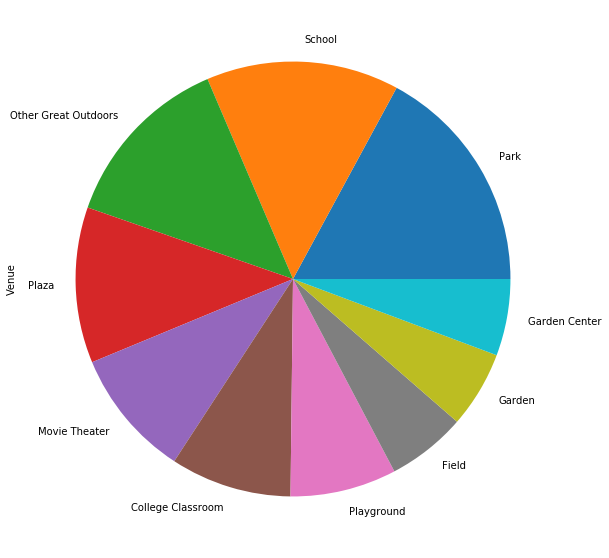

In [744]:
dfClusterSample = dfVenues_cluster_0.groupby(['Venue Category']).count()['Venue'].to_frame().reset_index()
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10).plot(kind = 'pie', figsize=(10, 10))

In [745]:
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10)

Venue Category
Park                    93
School                  78
Other Great Outdoors    72
Plaza                   63
Movie Theater           52
College Classroom       49
Playground              43
Field                   32
Garden                  31
Garden Center           31
Name: Venue, dtype: int64

# Cluster 1 (label 1 > Color PURPLE)


In [746]:
dfVenues_cluster_1=dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 1]
dfVenues_cluster_1.drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop = True)[0:5]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DAGANZO DE ARRIBA,1,Other Great Outdoors,Park,Plaza,Indoor Play Area,Garden,High School,Indie Movie Theater,Garden Center,School,College Classroom
1,DAGANZO DE ARRIBA,1,Other Great Outdoors,Park,Plaza,Indoor Play Area,Garden,High School,Indie Movie Theater,Garden Center,School,College Classroom
2,DAGANZO DE ARRIBA,1,Other Great Outdoors,Park,Plaza,Indoor Play Area,Garden,High School,Indie Movie Theater,Garden Center,School,College Classroom
3,DAGANZO DE ARRIBA,1,Other Great Outdoors,Park,Plaza,Indoor Play Area,Garden,High School,Indie Movie Theater,Garden Center,School,College Classroom
4,DAGANZO DE ARRIBA,1,Other Great Outdoors,Park,Plaza,Indoor Play Area,Garden,High School,Indie Movie Theater,Garden Center,School,College Classroom


In [747]:
dfVenues_cluster_1.groupby(['Neighborhood']).count()['Cluster Labels']

Neighborhood
DAGANZO DE ARRIBA       28
HOYO DE MANZANARES      34
TRES CANTOS             43
VALDEOLMOS-ALALPARDO    24
VENTURADA               17
VILLALBILLA             23
Name: Cluster Labels, dtype: int64

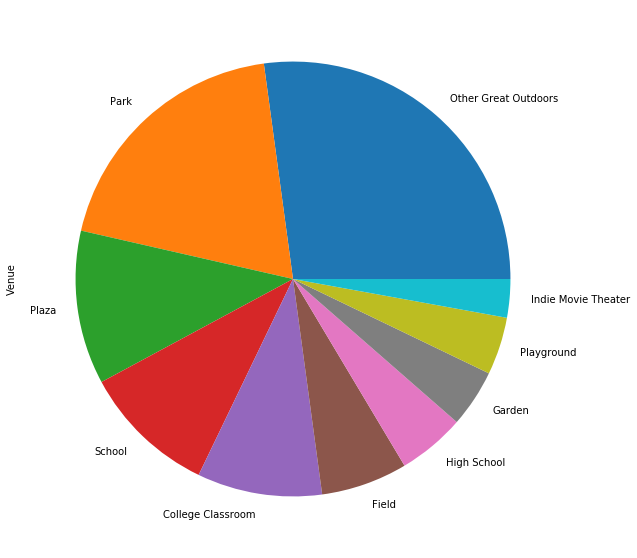

In [748]:
dfClusterSample = dfVenues_cluster_1.groupby(['Venue Category']).count()['Venue'].to_frame().reset_index()
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10).plot(kind = 'pie', figsize=(10, 10))

In [749]:
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10)

Venue Category
Other Great Outdoors    38
Park                    27
Plaza                   16
School                  14
College Classroom       13
Field                    9
High School              7
Garden                   6
Playground               6
Indie Movie Theater      4
Name: Venue, dtype: int64

# Cluster 2 (label 2 > Color LIGHT BLUE)

In [715]:
dfVenues_cluster_2=dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 2]
dfVenues_cluster_2.drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop = True)[0:5]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BECERRIL DE LA SIERRA,2,Playground,Park,Garden Center,School,Field,Plaza,Other Great Outdoors,Movie Theater,Indoor Play Area,Preschool
1,BECERRIL DE LA SIERRA,2,Playground,Park,Garden Center,School,Field,Plaza,Other Great Outdoors,Movie Theater,Indoor Play Area,Preschool
2,BECERRIL DE LA SIERRA,2,Playground,Park,Garden Center,School,Field,Plaza,Other Great Outdoors,Movie Theater,Indoor Play Area,Preschool
3,BECERRIL DE LA SIERRA,2,Playground,Park,Garden Center,School,Field,Plaza,Other Great Outdoors,Movie Theater,Indoor Play Area,Preschool
4,BECERRIL DE LA SIERRA,2,Playground,Park,Garden Center,School,Field,Plaza,Other Great Outdoors,Movie Theater,Indoor Play Area,Preschool


In [750]:
dfVenues_cluster_2.groupby(['Neighborhood']).count()['Cluster Labels']

Neighborhood
BECERRIL DE LA SIERRA    35
EL BOALO                 26
NAVACERRADA              32
SOTO DEL REAL            25
Name: Cluster Labels, dtype: int64

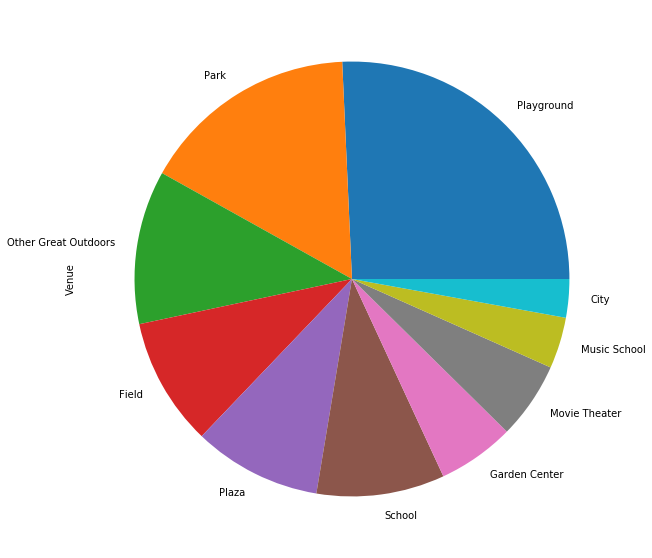

In [751]:
dfClusterSample = dfVenues_cluster_2.groupby(['Venue Category']).count()['Venue'].to_frame().reset_index()
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10).plot(kind = 'pie', figsize=(10, 10))

In [752]:
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10)

Venue Category
Playground              27
Park                    17
Other Great Outdoors    12
Field                   10
Plaza                   10
School                  10
Garden Center            6
Movie Theater            6
Music School             4
City                     3
Name: Venue, dtype: int64

# Cluster 3 (label 3 > Color LIGHT GREEN)

In [762]:
dfVenues_cluster_3=dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 3]
dfVenues_cluster_3.drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop = True)[0:5]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,VALDEMORILLO,3,Field,Playground,Indoor Play Area,Other Great Outdoors,Park,Garden Center,Garden,College Gym,Athletics & Sports,Drive-in Theater
1,VALDEMORILLO,3,Field,Playground,Indoor Play Area,Other Great Outdoors,Park,Garden Center,Garden,College Gym,Athletics & Sports,Drive-in Theater
2,VALDEMORILLO,3,Field,Playground,Indoor Play Area,Other Great Outdoors,Park,Garden Center,Garden,College Gym,Athletics & Sports,Drive-in Theater
3,VALDEMORILLO,3,Field,Playground,Indoor Play Area,Other Great Outdoors,Park,Garden Center,Garden,College Gym,Athletics & Sports,Drive-in Theater
4,VALDEMORILLO,3,Field,Playground,Indoor Play Area,Other Great Outdoors,Park,Garden Center,Garden,College Gym,Athletics & Sports,Drive-in Theater


In [763]:
dfVenues_cluster_3.groupby(['Neighborhood']).count()['Cluster Labels']

Neighborhood
VALDEMORILLO    22
Name: Cluster Labels, dtype: int64

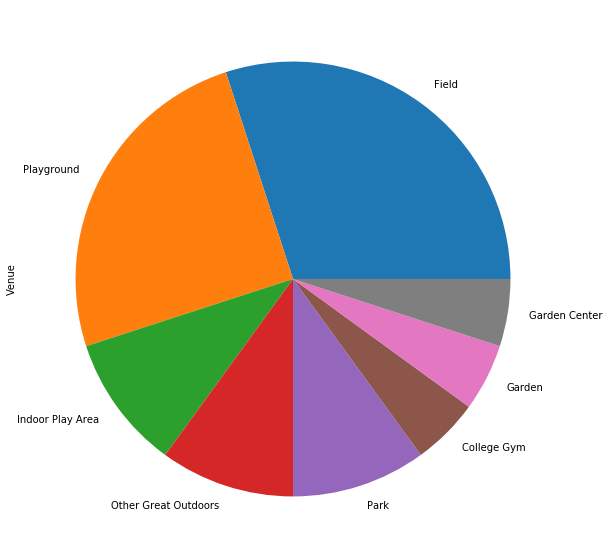

In [764]:
dfClusterSample = dfVenues_cluster_3.groupby(['Venue Category']).count()['Venue'].to_frame().reset_index()
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10).plot(kind = 'pie', figsize=(10, 10))

In [765]:
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10)

Venue Category
Field                   6
Playground              5
Indoor Play Area        2
Other Great Outdoors    2
Park                    2
College Gym             1
Garden                  1
Garden Center           1
Name: Venue, dtype: int64

# Cluster 4 (label 4 > Color LIGHT ORANGE)

In [758]:
dfVenues_cluster_4=dfVenues_merged.loc[dfVenues_merged['Cluster Labels'] == 4]
dfVenues_cluster_4.drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop = True)[0:5]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALCOBENDAS,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
1,ALCOBENDAS,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
2,ALCOBENDAS,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
3,ALCOBENDAS,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field
4,ALCOBENDAS,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field


In [759]:
dfVenues_cluster_4.groupby(['Neighborhood']).count()['Cluster Labels']

Neighborhood
ALCOBENDAS                    94
ALGETE                        33
ALPEDRETE                     67
COBEÑA                        29
COLLADO MEDIANO               58
EL ESCORIAL                   30
GALAPAGAR                     62
MORALZARZAL                   49
PARACUELLOS DE JARAMA         50
RIVAS-VACIAMADRID             32
SAN LORENZO DE EL ESCORIAL    32
SAN SEBASTIÁN DE LOS REYES    84
VILLANUEVA DE LA CAÑADA       40
Name: Cluster Labels, dtype: int64

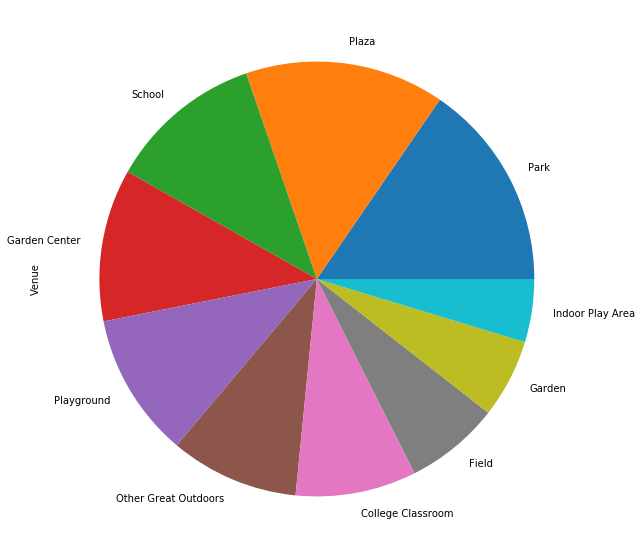

In [760]:
dfClusterSample = dfVenues_cluster_4.groupby(['Venue Category']).count()['Venue'].to_frame().reset_index()
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10).plot(kind = 'pie', figsize=(10, 10))

In [761]:
dfClusterSample.groupby(['Venue Category']).sum()['Venue'].nlargest(n = 10)

Venue Category
Park                    79
Plaza                   76
School                  59
Garden Center           58
Playground              55
Other Great Outdoors    49
College Classroom       46
Field                   36
Garden                  30
Indoor Play Area        24
Name: Venue, dtype: int64

In [775]:
dfVenues_cluster_plot=dfVenues_merged.drop(['Venue','Venue Category','Venue Latitude','Venue Longitude','Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis = 1).reset_index(drop = True)
dfVenues_cluster_plot['hit'] = 1

In [776]:
dfVenues_cluster_plot.head()


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,hit
0,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field,1
1,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field,1
2,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field,1
3,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field,1
4,4,Playground,Plaza,School,Other Great Outdoors,Park,Garden Center,College Classroom,Gym,Recreation Center,Field,1


In [802]:
dfVenues_cluster_plot_top5 = dfVenues_cluster_plot.groupby(['Cluster Labels','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']).count()['hit'].to_frame().sort_values(['Cluster Labels','hit'], ascending = False)

In [803]:
dfVenues_cluster_plot_top5.head(1000)

hit
Cluster Labels 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue     
4              Garden Center         Park                  Plaza                 Garden                Field                  125
               Playground            Plaza                 School                Other Great Outdoors  Park                    94
                                     School                Plaza                 Park                  Garden Center           84
               Plaza                 College Classroom     Park                  School                Other Great Outdoors    62
                                     School                Park                  College Classroom     Pedestrian Plaza        50
               Park                  Plaza                 Garden Center         Field                 Garden                  49
               Playground            College Classroom     Park                  Garden Center         School                  40
               Garden Center         School                Park                  Other Great Outdoors  Plaza                   33
               Other Great Outdoors  Park                  Garden Center         Playground            Indoor Play Area        32
               Plaza                 Park                  Other Great Outdoors  Playground            Field                   32
                                     Other Great Outdoors  Field                 Playground            Park                    30
               Garden Center         Plaza                 Playground            Other Great Outdoors  Park                    29
3              Field                 Playground            Indoor Play Area      Other Great Outdoors  Park                    22
2              Playground            Park                  Garden Center         School                Field                   35
                                                           Other Great Outdoors  Plaza                 Movie Theater           32
                                     Other Great Outdoors  Park                  School                Field                   26
               Park                  Playground            Other Great Outdoors  Plaza                 City                    25
1              Other Great Outdoors  Park                  College Classroom     School                Plaza                   43
                                     College Classroom     Park                  School                Field                   34
                                     Park                  Plaza                 Indoor Play Area      Garden                  28
                                                                                 School                High School             24
               Park                  Other Great Outdoors  Plaza                 Garden                Playground              23
               Other Great Outdoors  Elementary School     Nursery School        High School           Language School         17
0              Park                  Movie Theater         Plaza                 College Classroom     Other Great Outdoors   130
                                     Plaza                 Other Great Outdoors  School                College Classroom       94
                                     Other Great Outdoors  School                Playground            Movie Theater           93
                                                           Plaza                 School                Movie Theater           83
                                     School                Other Great Outdoors  Plaza                 Movie Theater           82
                                     College Classroom     Other Great Outdoors  Plaza                 School                  80
               School                Park                  College Classroom     Plaza          